# Transcript from Lecture, November 2, 2021

In [1]:
import sys

########################################
# Change the string in the line below! #
########################################
sys.path.append("/Users/gilbert/Documents/CS111-2021-fall/Python") 

import os
import time
import math
import numpy as np
import numpy.linalg as npla
import scipy
from scipy import linalg as spla
import scipy.sparse
import scipy.sparse.linalg
from scipy import integrate
import networkx as nx
import json
import cs111

##########################################################
# If this import for matplotlib doesn't work, try saying #
#   conda install -c conda-forge ipympl                  #
# at a shell prompt on your computer                     #
##########################################################
import matplotlib
%matplotlib ipympl

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d




np.set_printoptions(precision = 4)

# Round-off error: Errors due to rounding in floating-point

## Cancellation when subtracting almost equal numbers

In [2]:
1/3

0.3333333333333333

In [3]:
a = 1
a + 1/3 - a

0.33333333333333326

In [4]:
a = 100
a + 1/3 - a

0.3333333333333286

In [5]:
a = 1000000
a + 1/3 - a

0.33333333337213844

In [6]:
a = 10**10
a + 1/3 - a

0.33333396911621094

In [7]:
a = 10**15
a + 1/3 - a

0.375

In [8]:
a = 10**16
a + 1/3 - a

0.0

## Floating-point addition is not associative!

In [9]:
a = -1/2
b = 1/2
c = 2 ** -54

print("(a+b)+c:", (a+b)+c)
print()
print("a+(b+c):", a+(b+c))



(a+b)+c: 5.551115123125783e-17

a+(b+c): 0.0


In [10]:
cs111.print_float64((a+b)+c)
cs111.print_float64(a+(b+c))

input     : 5.551115123125783e-17
as float64: 5.5511151231257827e-17
as hex    : 3c90000000000000
sign      : 0 means +
exponent  : 3c9 means 969 - 1023 = -54
mantissa  : 1.0000000000000000000000000000000000000000000000000000

input     : 0.0
as float64: 0.0000000000000000e+00
as hex    : 0000000000000000
sign      : 0 means +
exponent  : 000 means zero or denormal



## Catastrophic cancellation in action: computing $(x-1)^7$

In [11]:
# A simple function of a real number x
def f1(x):
    return (x-1)**7

# Same function as f1, but multiplied out and written as a polynomial in x
def f2(x):
    return x**7 - 7*x**6 + 21*x**5 - 35*x**4 + 35*x**3 - 21*x**2 + 7*x - 1


In [12]:
x = 1
print('x:', x, '; (x-1)**7:', f1(x), ';  polynomial:', f2(x))

x: 1 ; (x-1)**7: 0 ;  polynomial: 0


In [13]:
x = 1.1
print('x:', x, '; (x-1)**7:', f1(x), ';  polynomial:', f2(x))

x: 1.1 ; (x-1)**7: 1.0000000000000062e-07 ;  polynomial: 1.0000000649768026e-07


In [14]:
x = 1.01
print('x:', x, '; (x-1)**7:', f1(x), ';  polynomial:', f2(x))

x: 1.01 ; (x-1)**7: 1.0000000000000062e-14 ;  polynomial: 1.4210854715202004e-14


In [15]:
x = 1.001
print('x:', x, '; (x-1)**7:', f1(x), ';  polynomial:', f2(x))

x: 1.001 ; (x-1)**7: 9.99999999999229e-22 ;  polynomial: 8.881784197001252e-15


/Users/gilbert/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'relative error in polynomial f2(x)')

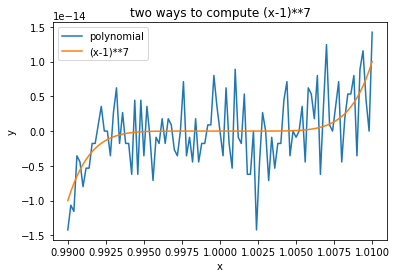

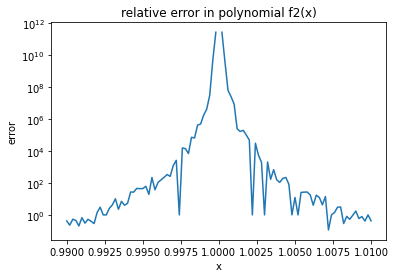

In [16]:
xvals = np.linspace(.99, 1.01, 101)

y1 = []
y2 = []
for x in xvals:
    y1.append(f1(x))
    y2.append(f2(x))
y1 = np.array(y1)
y2 = np.array(y2)

%matplotlib inline
plt.figure()
plt.plot(xvals, y2, label = 'polynomial')
plt.plot(xvals, y1, label = '(x-1)**7')
plt.xlabel('x')
plt.ylabel('y')
plt.title('two ways to compute (x-1)**7')
plt.legend()

plt.figure()
plt.semilogy(xvals, np.abs((y1-y2)/y1))
plt.xlabel('x')
plt.ylabel('error')
plt.title('relative error in polynomial f2(x)')


# Round-off error in LU with partial pivoting

# Data fitting by least squares

## The surveyor problem

In [17]:
A = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1,1]])
b = np.array([1237,1941,2417,711,1177,475])
print('A:'); print(A)
print('\nb:', b)

A:
[[ 1  0  0]
 [ 0  1  0]
 [ 0  0  1]
 [-1  1  0]
 [-1  0  1]
 [ 0 -1  1]]

b: [1237 1941 2417  711 1177  475]


In [18]:
x = npla.solve(A,b)

LinAlgError: Last 2 dimensions of the array must be square

In [19]:
x, resid, rank, sv = npla.lstsq(A, b, rcond = None)
x

array([1236., 1943., 2416.])

In [21]:
npla.lstsq?


In [22]:
x = npla.lstsq(A, b, rcond = None)[0]
x

array([1236., 1943., 2416.])

In [23]:
b - A@x

array([ 1., -2.,  1.,  4., -3.,  2.])

In [24]:
relres = npla.norm(b - A@x)/npla.norm(b)
print('relres =', relres)

relres = 0.001624903391484253


In [25]:
first_surveyor_x = np.array([1237,1941,2417])
relres = npla.norm(b - A @ first_surveyor_x)/npla.norm(b)
print("first surveyor's relres =", relres)

first surveyor's relres = 0.002109694296525749


## Fitting a linear-regression line to data

<b>Warning: This data originated from a real source (SDSS), but it has been messed around with and should be thought of as only a toy example.

In [26]:
u = np.array([
24.41442,
25.67274,
26.02992,
23.00638,
24.86972,
21.96248,
21.87139,
24.93143,
22.90206,
22.749,
23.84269,
21.74025,
23.87719,
19.22808,
21.62093,
25.31738,
24.78468,
26.16757,
24.25187,
23.59213,
22.67077,
25.01685,
25.43069,
24.23741,
22.36275,
24.56208,
21.57241,
28.41815,
25.05081,
20.96467,
23.56018,
23.45984,
22.8903,
22.97415,
20.78101,
22.46072,
24.60077,
24.78432,
23.35197,
24.09856,
25.7874,
22.36821,
24.50825,
22.06679,
16.63657,
24.38522,
26.19138,
21.29271])

z = np.array([
21.37779,
21.2569,
19.88106,
20.76563,
23.18144,
19.76097,
18.34194,
21.97318,
18.26459,
20.63926,
21.69268,
18.20393,
20.19502,
15.4874,
21.864,
22.357,
22.36432,
20.08167,
20.08758,
20.00934,
19.9816,
21.85483,
19.38139,
17.90937,
16.79848,
22.54093,
18.07866,
27.90404,
21.32371,
17.1744,
18.08388,
22.01883,
19.4599,
22.5115,
16.82848,
21.34581,
20.29847,
22.91343,
19.40759,
21.99136,
22.56684,
19.13174,
22.60053,
20.24307,
13.87426,
19.74682,
21.74273,
17.74383])/100

In [27]:
u.shape

(48,)

In [28]:
z.shape

(48,)

Text(0.5, 1.0, 'Hubble diagram: magnitude and red shift of astronomical objects')

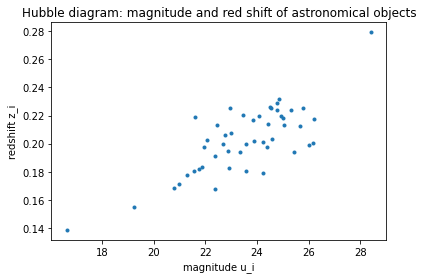

In [29]:
%matplotlib inline
plt.figure()
plt.plot(u,z,'.')
plt.xlabel('magnitude u_i')
plt.ylabel('redshift z_i')
plt.title('Hubble diagram: magnitude and red shift of astronomical objects')

In [30]:
m = len(u)
A = np.ones((m,2))
A[:,1] = u
A.shape

(48, 2)

In [31]:
A

array([[ 1.    , 24.4144],
       [ 1.    , 25.6727],
       [ 1.    , 26.0299],
       [ 1.    , 23.0064],
       [ 1.    , 24.8697],
       [ 1.    , 21.9625],
       [ 1.    , 21.8714],
       [ 1.    , 24.9314],
       [ 1.    , 22.9021],
       [ 1.    , 22.749 ],
       [ 1.    , 23.8427],
       [ 1.    , 21.7402],
       [ 1.    , 23.8772],
       [ 1.    , 19.2281],
       [ 1.    , 21.6209],
       [ 1.    , 25.3174],
       [ 1.    , 24.7847],
       [ 1.    , 26.1676],
       [ 1.    , 24.2519],
       [ 1.    , 23.5921],
       [ 1.    , 22.6708],
       [ 1.    , 25.0169],
       [ 1.    , 25.4307],
       [ 1.    , 24.2374],
       [ 1.    , 22.3627],
       [ 1.    , 24.5621],
       [ 1.    , 21.5724],
       [ 1.    , 28.4182],
       [ 1.    , 25.0508],
       [ 1.    , 20.9647],
       [ 1.    , 23.5602],
       [ 1.    , 23.4598],
       [ 1.    , 22.8903],
       [ 1.    , 22.9742],
       [ 1.    , 20.781 ],
       [ 1.    , 22.4607],
       [ 1.    , 24.6008],
 

In [32]:
x = npla.lstsq(A, z, rcond = None)[0]
x

array([-0.0113,  0.0091])

In [33]:
np.linspace(15,30,num=4)

array([15., 20., 25., 30.])

Text(0.5, 1.0, 'Hubble diagram: magnitude and red shift of astronomical objects')

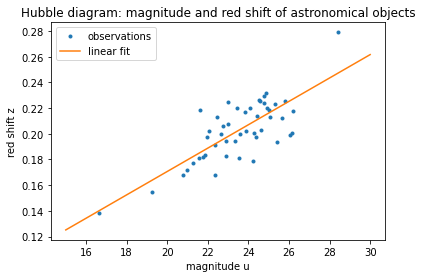

In [34]:
%matplotlib inline
plt.figure()
plt.plot(u,z,'.')
lineu = np.linspace(15,30,num=4)
linez = x[0] + x[1]*lineu
plt.plot(lineu,linez)
plt.xlabel('magnitude u')
plt.ylabel('red shift z')
plt.legend(('observations', 'linear fit'))
plt.title('Hubble diagram: magnitude and red shift of astronomical objects')

In [ ]:
x

## SVD and least squares

In [ ]:
# The surveyors again

A = np.array([[1,0,0],[0,1,0],[0,0,1],[-1,1,0],[-1,0,1],[0,-1,1]])
b = np.array([1237,1941,2417,711,1177,475])
print('A:'); print(A)
print()
print('b:', b)

In [ ]:
U,sigma,Vt = npla.svd(A)

print('singular values:', sigma)
print()

S = np.zeros(A.shape)
for i, s in enumerate(sigma):
    S[i,i] = s
    
V = Vt.T

print('U:'); print(U)
print()
print('S:'); print(S)
print()
print('V:'); print(V)

In [ ]:
print('A:'); print(A)
print()
print('U @ S @ V.T:'); print(U @ S @ V.T)


In [ ]:
npla.norm(A - U@S@V.T)

The least squares problem is to find the $x$ that minimizes the 2-norm $||Ax-b||_2$. We can use SVD to solve this, because multiplication by an orthogonal matrix doesn't change the 2-norm of a vector.

We want to minimize 

$$||Ax-b|| = ||USV^Tx-b||.$$

Multiplying by the orthogonal matrix $U^T$, this is the same as minimizing 

$$||U^TUSV^Tx - U^Tb|| = ||SV^Tx-U^Tb||.$$

Define $y=V^Tx$. Then if we can somehow find the $y$ that minimizes

$$||Sy - U^Tb||,$$

we can compute $x = Vy$ and we'll be done.

In [ ]:
print('b:', b)
print('U.T @ b:', U.T@b)

In [ ]:
print('S:'); print(S)
print()
print('sigma:', sigma)

The bottom part of $S$ is zero. Therefore the bottom part of $Sy$ will be zero no matter what $y$ is, and the best we can do to minimize $||Sy - U^Tb||$ is to make the top part of $Sy$ match the top part of $U^Tb$.

That's easy because the top part of $S$ is diagonal.

In [ ]:
print('first 3 elements of U.T @ b:', (U.T @ b)[:3])

In [ ]:
y = (U.T @ b)[:3] / sigma

print('y:', y)

In [ ]:
x = V@y

print('x:', x)

In [ ]:
print('npla.lstsq x:', npla.lstsq(A, b, rcond=None)[0])

In [ ]:
npla.norm(A@x - b)

In [ ]:
npla.norm(S@y - U.T@b)

In [ ]:
print('S@y:', S@y)
print()
print('U.T@b:', U.T@b)
print()
print('S@y - U.T@b:', S@y - U.T@b)

In [ ]:
npla.norm((U.T@b)[3:])